In [1]:
#Not all these packages are required but they are here for completeness
import glob
import importlib
import io
from ipywidgets import interact
from ipywidgets import fixed
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
import seaborn as sns
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import morphology
import time
import warnings

In [2]:
# Import package 

BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

os.chdir(HEMNET_DIR)
from slide import *
from utils import *

In [3]:
import utils
importlib.reload(utils)
from utils import *

In [4]:
# User Input parameters

SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg')

ALIGNMENT_MAG = 2
TILE_MAG = 10
VERBOSE = True

In [47]:
#Verbose functions

if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None

In [6]:
# Find Slides

slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
slides

['1820_N_10545A_2_HandE.svs',
 '1820_N_10545A_4_TP53.svs',
 '1820_T_105452F_2_HandE.svs',
 '1820_T_105452F_4_TP53.svs',
 '2065_N_12752A_2_HandE.svs',
 '2065_N_12752A_4_TP53.svs',
 '2065_T_12756A_2_HandE.svs',
 '2065_T_12756A_4_TP53.svs',
 '2112_N_12341B_2_HandE.svs',
 '2112_N_12341B_4_TP53.svs',
 '2112_T_12335F_2_HandE.svs',
 '2112_T_12335F_4_TP53.svs',
 '2148_N_11397A_2_HandE.svs',
 '2148_N_11397A_4_TP53.svs',
 '2148_T_11393A_2_HandE.svs',
 '2148_T_11393A_4_TP53.svs',
 '2171_N_11521A_2_HandE.svs',
 '2171_N_11521A_4_TP53.svs',
 '2171_T_11524A_2_HandE.svs',
 '2171_T_11524A_4_TP53.svs']

In [7]:
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
Paired_slides

[('1820_N_10545A_4_TP53.svs', '1820_N_10545A_2_HandE.svs'),
 ('1820_T_105452F_4_TP53.svs', '1820_T_105452F_2_HandE.svs'),
 ('2065_N_12752A_4_TP53.svs', '2065_N_12752A_2_HandE.svs'),
 ('2065_T_12756A_4_TP53.svs', '2065_T_12756A_2_HandE.svs'),
 ('2112_N_12341B_4_TP53.svs', '2112_N_12341B_2_HandE.svs'),
 ('2112_T_12335F_4_TP53.svs', '2112_T_12335F_2_HandE.svs'),
 ('2148_N_11397A_4_TP53.svs', '2148_N_11397A_2_HandE.svs'),
 ('2148_T_11393A_4_TP53.svs', '2148_T_11393A_2_HandE.svs'),
 ('2171_N_11521A_4_TP53.svs', '2171_N_11521A_2_HandE.svs'),
 ('2171_T_11524A_4_TP53.svs', '2171_T_11524A_2_HandE.svs')]

In [8]:
SLIDE_NUM = 2
PREFIX = Paired_slides[SLIDE_NUM][0][:-8]
verbose_print('Processing Slide: {0}'.format(PREFIX))
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

Processing Slide: 2065_N_12752A_4_


In [9]:
def thumbnail(img, size = (1000,1000)):
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [10]:
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

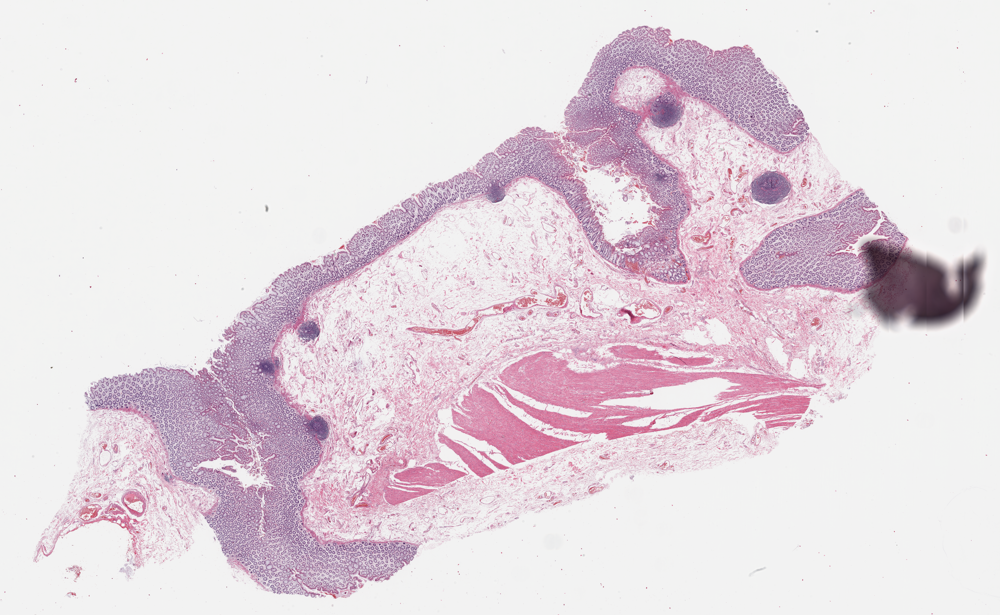

In [11]:
thumbnail(he)

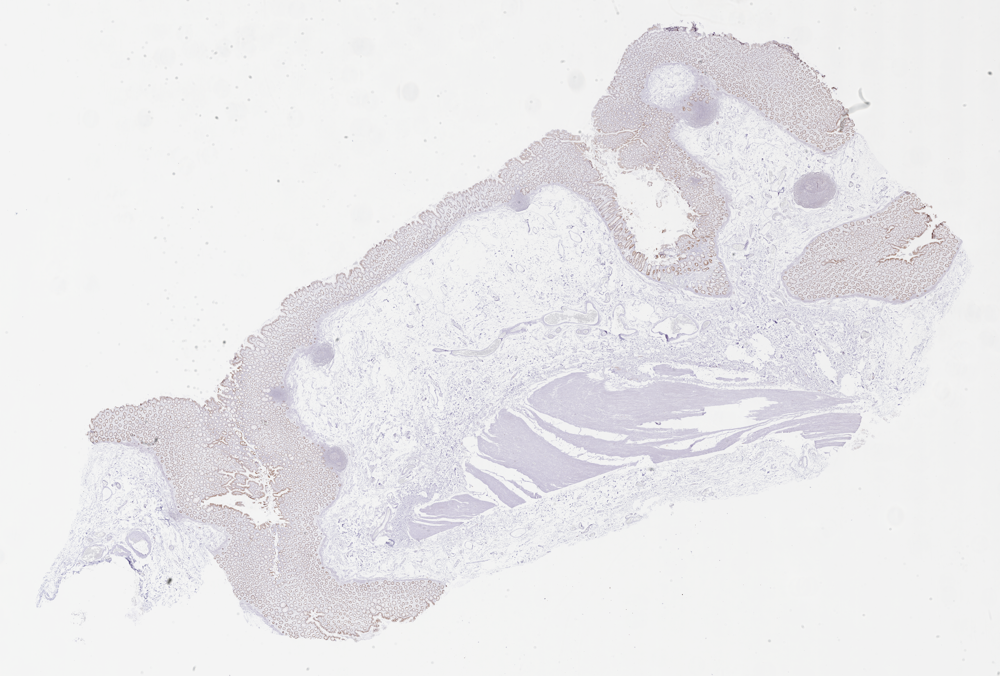

In [12]:
thumbnail(tp53)

In [13]:
#Convert to grayscale
tp53_gray = tp53.convert('L')
he_gray = he.convert('L')
#Convert to ITK format
tp53_itk = get_itk_from_pil(tp53_gray)
he_itk = get_itk_from_pil(he_gray)

In [14]:
def sitk_transform_rgb(moving_rgb_img, fixed_rgb_img, transform, interpolator = sitk.sitkLinear):
    """Applies a Simple ITK transform (e.g. Affine, B-spline) to an RGB image
    
    The transform is applied to each channel
    
    Parameters
    ----------
    moving_rgb_img : Pillow Image 
        This image will be transformed to produce the output image
    fixed_rgb_img : Pillow Image
        This reference image provides the output information (spacing, size, and direction) of the output image
    transform : SimpleITK transform
        Generated from image registration
    interpolator : SimpleITK interpolator
    
    Returns
    -------
    rgb_transformed : Pillow Image
        Transformed moving image 
    """
    transformed_channels = []
    r_moving, g_moving, b_moving, = moving_rgb_img.convert('RGB').split()
    r_fixed, g_fixed, b_fixed = fixed_rgb_img.convert('RGB').split()
    for moving_img, fixed_img in [(r_moving, r_fixed), (g_moving, g_fixed), (b_moving, b_fixed)]:
        moving_img_itk = get_itk_from_pil(moving_img)
        fixed_img_itk = get_itk_from_pil(fixed_img)
        transformed_img = sitk.Resample(moving_img_itk, fixed_img_itk, transform, 
                            interpolator, 0.0, moving_img_itk.GetPixelID())
        transformed_channels.append(get_pil_from_itk(transformed_img))
    rgb_transformed = Image.merge('RGB', transformed_channels)
    return rgb_transformed    

In [15]:
#Check Initial Registration
fixed_img = he_itk
moving_img = tp53_itk
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
moving_resampled = sitk.Resample(moving_img, fixed_img, initial_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())

In [16]:
moving_rgb = sitk_transform_rgb(tp53, he, initial_transform)

In [17]:
comparison_pre = show_alignment(he, moving_rgb, prefilter = True)

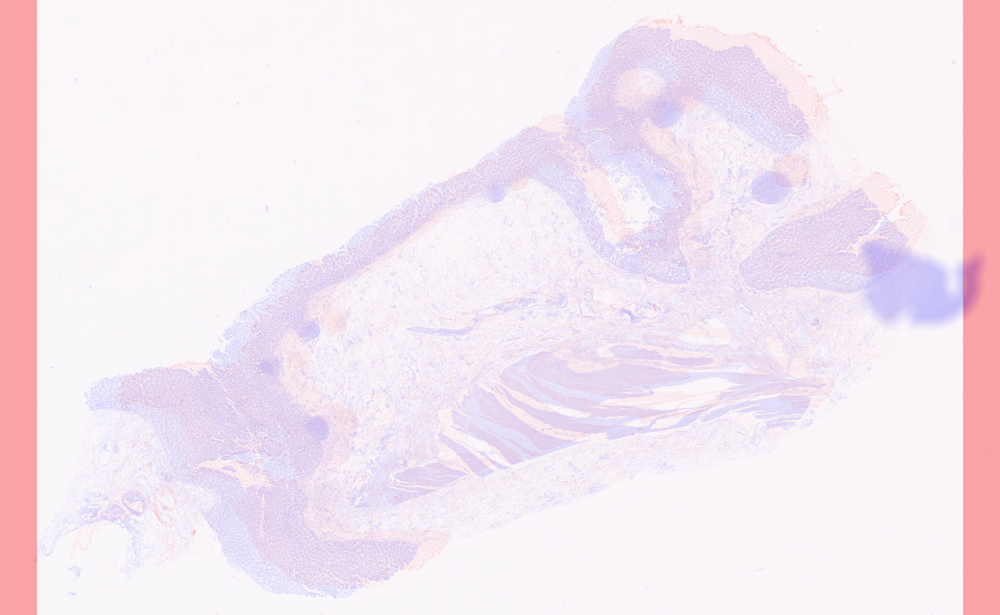

In [18]:
thumbnail(comparison_pre)

In [362]:
verbose_save_img(comparison_pre.convert('RGB'), OUTPUT_PATH.joinpath(PREFIX + 'comparison_pre_registration.jpeg'), 'JPEG' )

### Image Registration

To enable labelling of H&E images from the TP53 images, these two images must be aligned to each other. Due to differences in sample preparation and imaging, these images are often not aligned so we need to register them to each other. 

In image registration, one image is set a fixed image and the other set as a moving image - it is the moving image that is tranformed to best align it to the fixed image. Here we set the H&E image as the fixed image and the TP53 Image as the moving image. We do this as the H&E image will later be used to train a convolutional neural network and we want the network to be able to use original patient H&E images. Thus, it is best that the images used to the train the network is in the same format as patient samples. 

In [19]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [20]:
################################
# Mutual Information Functions #
################################

def mutual_information(hgram):
    """Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis = 1) # marginal for x over y
    py = np.sum(pxy, axis = 0) # marginal for y over x
    px_py = px[:, None] * py[None, :] #Broadcat to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays 
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mutual_info_histogram(fixed_img, moving_img, bins = 20, log = False):
    hist_2d, x_edges, y_edges = np.histogram2d(fixed_img.ravel(), moving_img.ravel(), bins = bins)
    if log:
        hist_2d_log = np.zeros(hist_2d.shape)
        non_zeros = hist_2d != 0
        hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
        return hist_2d_log
    return hist_2d

def plot_mutual_info_histogram(histogram):
    plt.imshow(histogram.T, origin = 'lower')
    plt.xlabel('Fixed Image')
    plt.ylabel('Moving Image')
    
def calculate_mutual_info(fixed_img, moving_img):
    hist = mutual_info_histogram(fixed_img, moving_img)
    return mutual_information(hist)

In [21]:
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*sitk.GetArrayViewFromImage(fixed) + alpha*sitk.GetArrayViewFromImage(moving)
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(img,cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()

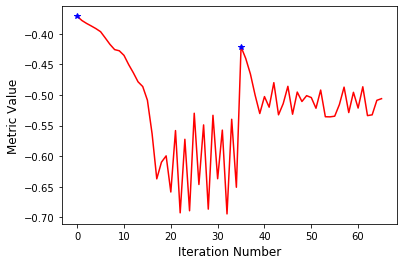

Affine metric value: -0.4863144132342343
Affine Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 31.


In [48]:
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
affine_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
affine_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
affine_method.SetMetricSamplingStrategy(affine_method.RANDOM)
affine_method.SetMetricSamplingPercentage(0.15)

affine_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
affine_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
affine_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
affine_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4])
affine_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2])
affine_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
affine_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
affine_method.AddCommand(sitk.sitkStartEvent, start_plot)
affine_method.AddCommand(sitk.sitkEndEvent, end_plot)
affine_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
affine_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(affine_method))

affine_transform = affine_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_img, sitk.sitkFloat32))

verbose_print('Affine metric value: {0}'.format(affine_method.GetMetricValue()))
verbose_print('Affine Optimizer\'s stopping condition, {0}'.format(affine_method.GetOptimizerStopConditionDescription()))

In [100]:
moving_resampled_affine = sitk.Resample(moving_img, fixed_img, affine_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
affine_mutual_info = calculate_mutual_info(np.array(he_gray), np.array(get_pil_from_itk(moving_resampled_affine)))
verbose_print('Affine mutual information metric: {0}'.format(affine_mutual_info))

Affine mutual information metric: 0.26503109726705937


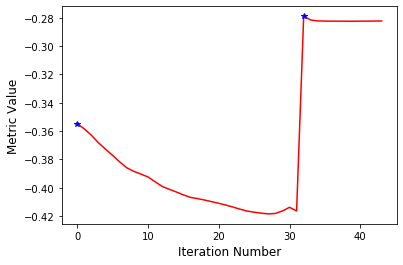

B-spline metric value: -0.28227212657792855
B-spline Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 12.


In [99]:
bspline_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
bspline_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
bspline_method.SetMetricSamplingStrategy(bspline_method.RANDOM)
bspline_method.SetMetricSamplingPercentage(0.15)

bspline_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
bspline_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=200, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
bspline_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
bspline_method.SetShrinkFactorsPerLevel(shrinkFactors = [2,1])
bspline_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1,0])
bspline_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
transformDomainMeshSize = [8]*moving_resampled_affine.GetDimension()
initial_transform = sitk.BSplineTransformInitializer(fixed_img, transformDomainMeshSize)
bspline_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
bspline_method.AddCommand(sitk.sitkStartEvent, start_plot)
bspline_method.AddCommand(sitk.sitkEndEvent, end_plot)
bspline_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
bspline_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(bspline_method))

bspline_transform = bspline_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_resampled_affine, sitk.sitkFloat32))

verbose_print('B-spline metric value: {0}'.format(bspline_method.GetMetricValue()))
verbose_print('B-spline Optimizer\'s stopping condition, {0}'.format(bspline_method.GetOptimizerStopConditionDescription()))

In [101]:
moving_resampled_final = sitk.Resample(moving_resampled_affine, fixed_img, bspline_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
bspline_mutual_info = calculate_mutual_info(np.array(he_gray), np.array(get_pil_from_itk(moving_resampled_final)))
verbose_print('B-spline mutual information metric: {0}'.format(bspline_mutual_info))

B-spline mutual information metric: 0.3033533820571987


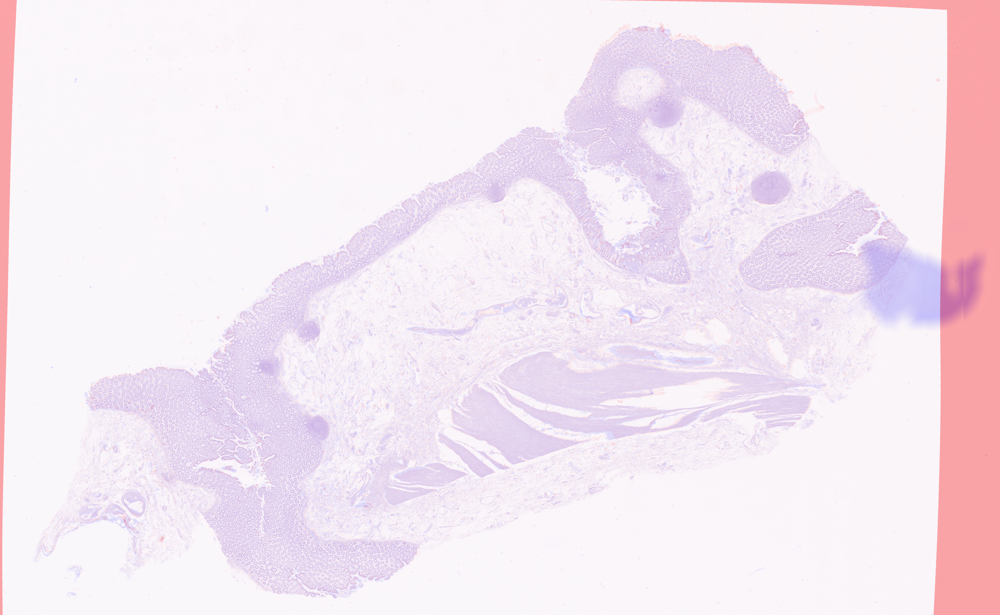

In [102]:
moving_rgb_affine = sitk_transform_rgb(tp53, he, affine_transform, sitk.sitkLinear)
tp53_aligned = sitk_transform_rgb(moving_rgb_affine, he, bspline_transform)
thumbnail(show_alignment(he, tp53_aligned, prefilter = True))

In [60]:
start = time.time()
tp53_filtered = filter_green(tp53_aligned)
he_filtered = filter_green(he)
green_end = time.time()
tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
he_filtered = filter_grays(he_filtered, tolerance = 15)
gray_end = time.time()
print('Time to Filter Green: {0}'.format(green_end - start))
print('Time to Filter Gray: {0}'.format(gray_end - green_end))

Time to Filter Green: 0.5046267509460449
Time to Filter Gray: 0.769000768661499


In [61]:
comparison_post = show_alignment(he_filtered, tp53_filtered)

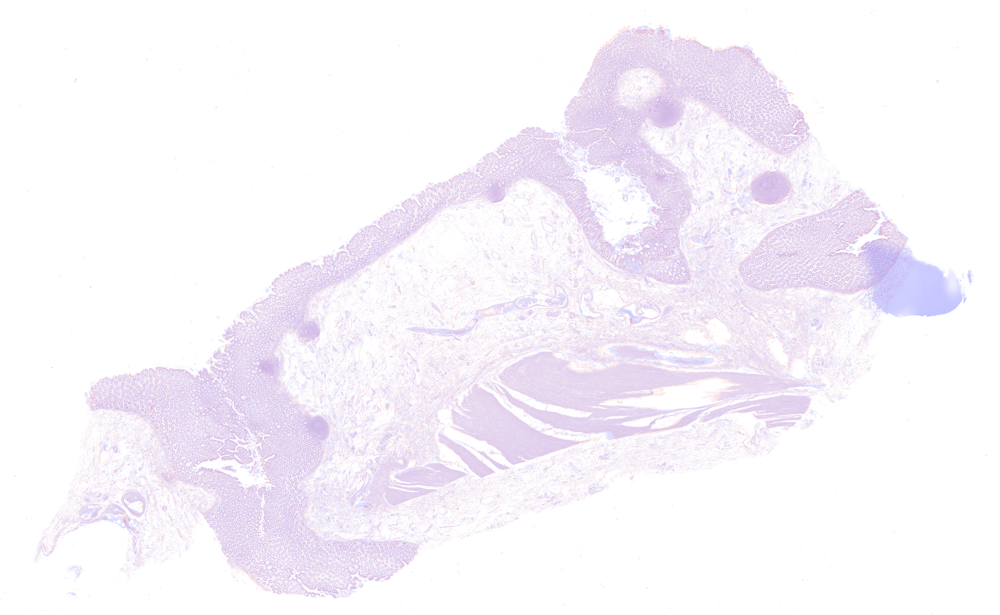

In [62]:
thumbnail(comparison_post)

In [64]:
verbose_save_img(comparison_post.convert('RGB'), OUTPUT_PATH.joinpath(PREFIX + 'comparison_post_registration.jpeg'), 'JPEG' )

### Tile Masks

In [30]:
##################
# Mask Functions #
##################

def threshold_otsu_masked(hed_img):
    """Otsu thresholds the DAB component of an image
       Masks the background so only tissue regions are used for threshold calculation
    """
    dab = -hed_img[:, :, 2]
    hem = -hed_img[:,:, 0]
    hem_thresh = threshold_otsu(hem)
    hem_binary_otsu = hem > hem_thresh
    #Use binary mask to mask out background of DAB images
    dab_masked = np.where(hem_binary_otsu == False, dab, 0)
    dab_values = np.array([i for i in dab_masked.ravel() if i != 0])
    #Otsu Thresholding
    hist, bin_centers = histogram(dab_values, 256)
    hist = hist.astype(float)
    # class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of `weight1`/`mean1` should pair with zero values in
    # `weight2`/`mean2`, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    #Consider all cells are normal if variance is too small
    if variance12[idx] < 500000:
        threshold = 0
    else:
        threshold = bin_centers[:-1][idx]
    return threshold

def ihc2gray(img):
    """Converts binary images to grayscale image
    """
    img_rescaled = (img*255).astype('uint8')
    return Image.fromarray(img_rescaled).convert('L')
            
def cancer_mask(img, tile_size, cancer_thresh):
    #Determine Dab threshold with a smaller 1000x1000 image
    downsample = max(img.size)/1000
    img_small_size = tuple([np.int(np.round(dim/downsample)) for dim in img.size])
    img_small = img.resize(img_small_size, resample = Image.BICUBIC)
    hed_small = rgb2hed(img_small)
    dab_thresh = threshold_otsu_masked(hed_small)
    mask = []
    tgen = tile_gen(img, tile_size)
    shape = next(tgen)
    for tile in tgen:
        tile = tile.convert('RGB')
        tile_hed = rgb2hed(tile)
        tile_dab = -tile_hed[:,:,2]
        binary_dab = tile_dab > dab_thresh
        if np.array(ihc2gray(binary_dab)).mean() < cancer_thresh:
            mask.append(0)
        else:
            mask.append(1)
    return np.reshape(mask, shape)  

def threshold_mask(tile_gen, threshold):
    """Creates mask from tiles using a threshold
    """
    mask = []
    shape = next(tile_gen)
    for tile in tile_gen:
        if np.array(tile).mean() < threshold:
            mask.append(0)
        else:
            mask.append(1)
    return np.reshape(mask, shape)

def show_mask(mask):
    return plt.imshow(np.reshape(mask, mask.shape[::-1]))

In [31]:
tile_size = 299*ALIGNMENT_MAG/TILE_MAG

In [32]:
#Generate cancer mask and tissue mask from filtered tp53 image
c_mask = cancer_mask(tp53_filtered, tile_size, 250)
tgen = tile_gen(tp53_filtered, tile_size)
t_mask_tp53 = threshold_mask(tgen, 250)
tgen = tile_gen(he_filtered, tile_size)
t_mask_he = threshold_mask(tgen, 250)

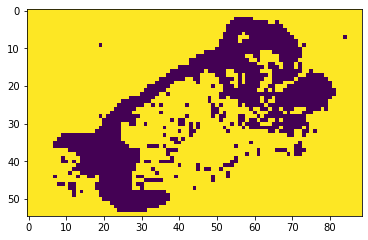

In [33]:
show_mask(c_mask)

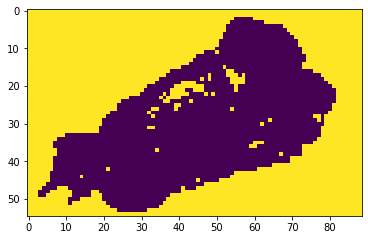

In [34]:
show_mask(t_mask_tp53)

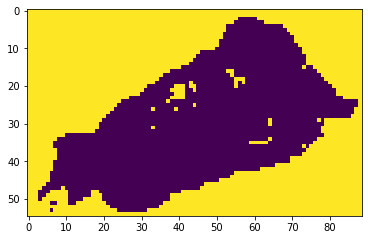

In [35]:
show_mask(t_mask_he)

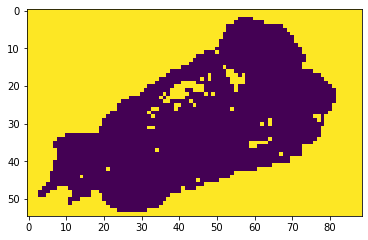

In [36]:
t_mask = np.logical_not(np.logical_not(t_mask_tp53) & np.logical_not(t_mask_he))
show_mask(t_mask)

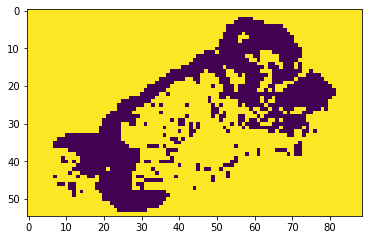

In [37]:
c_mask_filtered = np.logical_not(np.logical_not(c_mask) & np.logical_not(t_mask))
show_mask(c_mask_filtered)

In [38]:
def max_tiles(img_dim, tile_dim, overlap):
    max_tiles = ((img_dim/tile_dim) - 1)/(1- overlap) + 1
    return int(np.floor(max_tiles))

def tile_coordinates(img, tile_size, overlap = 0):
    '''Input is Pillow Image
    '''
    width, height = img.size
    x_tiles = max_tiles(width, tile_size, overlap)
    y_tiles = max_tiles(height, tile_size, overlap)
    coords = []
    for y in range(y_tiles):
        for x in range(x_tiles):
            x_top_left = x*tile_size*(1-overlap)
            y_top_left = y*tile_size*(1-overlap)
            x_bottom_right = x_top_left + tile_size
            y_bottom_right = y_top_left + tile_size
            coords.append([x, y, x_top_left, y_top_left, x_bottom_right, y_bottom_right])
    return pd.DataFrame(coords, columns = ['X','Y','x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right'])

In [39]:
def plot_mask(img, mask, tile_size):
    img_overlay = img.copy()
    d = ImageDraw.Draw(img_overlay)
    tile_coords = tile_coordinates(img, tile_size)
    tile_coords['mask'] = mask.ravel()
    width = int(np.round(tile_size*0.03))
    for index, row in tile_coords.iterrows():
        x_top_left, y_top_left = np.round(row['x_top_left':'y_top_left'])
        x_bottom_right, y_bottom_right = np.ceil(row['x_bottom_right':'y_bottom_right'])
        if row['mask'] == 0:
            outline = 'red'
        else:
            outline = 'grey'
        d.rectangle([(x_top_left, y_top_left), (x_bottom_right, y_bottom_right)], outline = outline, width = width)
    return img_overlay

def plot_masks(img, c_mask, t_mask, tile_size):
    img_overlay = img.copy()
    d = ImageDraw.Draw(img_overlay)
    tile_coords = tile_coordinates(img, tile_size)
    tile_coords['c_mask'] = c_mask.ravel()
    tile_coords['t_mask'] = t_mask.ravel()
    width = int(np.round(tile_size*0.03))
    for row in tile_coords.itertuples(index = False):
        x_top_left, y_top_left = np.round(row[2:4])
        x_bottom_right, y_bottom_right = np.ceil(row[4:6])
        if row[6] == 0:
            outline = 'red'
        elif row[7] == 0:
            outline = 'lime'
        else:
            outline = 'grey'
        d.rectangle([(x_top_left, y_top_left), (x_bottom_right, y_bottom_right)], outline = outline, width = width)
    return img_overlay

In [83]:
overlay_tp53 = plot_masks(tp53_filtered, c_mask_filtered, t_mask, tile_size)

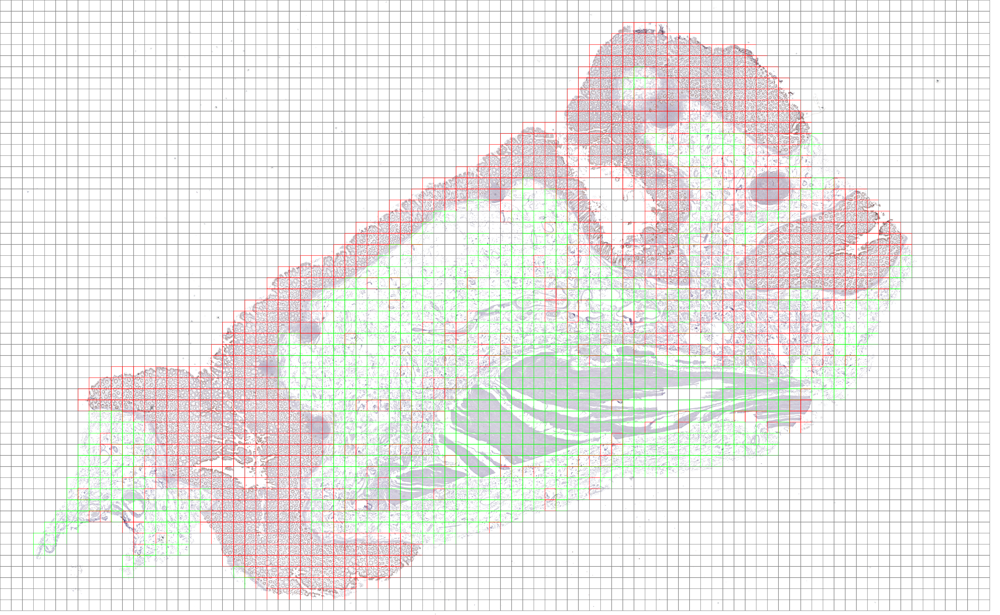

In [84]:
thumbnail(overlay_tp53)

In [55]:
verbose_save_img(overlay_tp53.convert('RGB'), OUTPUT_PATH.joinpath(PREFIX + 'TP53_overlay.jpeg'), 'JPEG' )

In [85]:
overlay_he = plot_masks(he_filtered, c_mask_filtered, t_mask, tile_size)

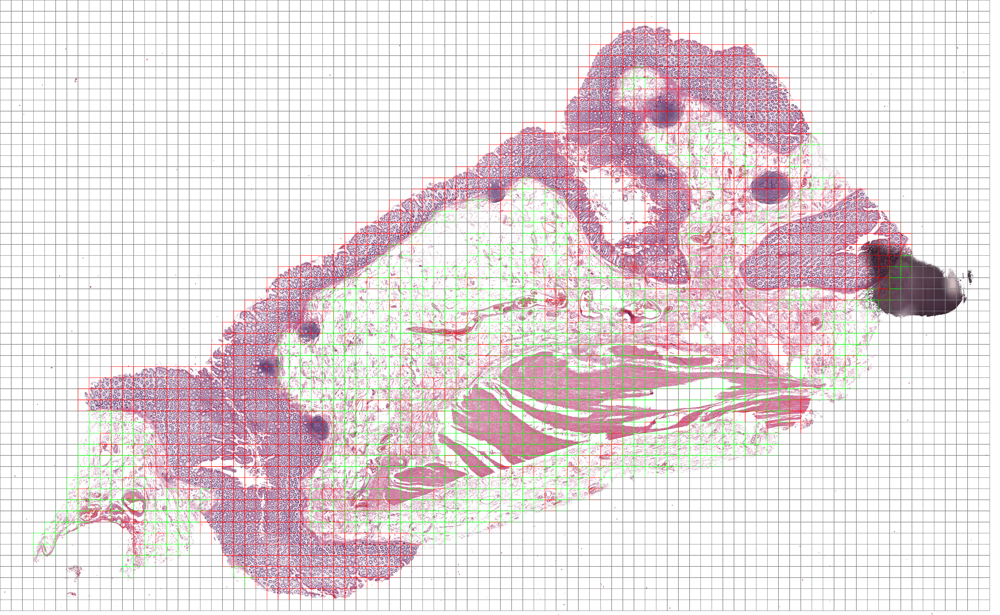

In [86]:
thumbnail(overlay_he)

In [56]:
verbose_save_img(overlay_he.convert('RGB'), OUTPUT_PATH.joinpath(PREFIX + 'HE_overlay.jpeg'), 'JPEG' )

In [73]:
##############
# Save Tiles #
##############

#Make Directory to save tiles
TILES_PATH = OUTPUT_PATH.joinpath('tiles_' + str(TILE_MAG) + 'x') 
os.makedirs(TILES_PATH, exist_ok = True )

In [95]:
def tile_gen_at_mag(wsi, mag, tile_size):
    """Generates tiles from whole slide images
    """
    #Get size of WSI at Level 0 (Max Magnification)
    x0, y0 = wsi.level_dimensions[0]
    #Get size of WSI at the mag we want
    x_mag, y_mag = get_size_for_mag(wsi, mag)
    x_tiles = int(np.floor(x_mag/tile_size))
    y_tiles = int(np.floor(y_mag/tile_size))
    #Scale tile size accordingly
    scale = highest_mag(wsi)/mag
    yield (x_tiles, y_tiles)
    tiles = []
    for y in range(y_tiles):
        for x in range(x_tiles):
            x_coord = round(x*scale*tile_size)
            y_coord = round(y*scale*tile_size)
            tile = wsi.read_region((x_coord, y_coord), 0, (tile_size, tile_size))
            yield tile.resize((tile_size, tile_size), resample = Image.BICUBIC)
            
def save_tiles(path, tile_gen, cancer_mask, tissue_mask, prefix = ''):
    os.makedirs(TILES_PATH.joinpath('cancer'), exist_ok = True)
    os.makedirs(TILES_PATH.joinpath('non-cancer'), exist_ok = True)
    x_tiles, y_tiles = next(tile_gen)
    verbose_print('Whole Image Size is {0} x {1}'.format(x_tiles, y_tiles))
    i = 0 
    for tile in tile_gen:
        img = tile.convert('RGB')
        #Name tile as horizontal position _ vertical position starting at (0,0)
        tile_name = prefix + str(np.floor_divide(i,x_tiles)) + '_' +  str(i%x_tiles) 
        if cancer_mask.ravel()[i] == 0:
            img.save(path.joinpath('cancer', tile_name + '.jpeg'), 'JPEG')
        elif tissue_mask.ravel()[i] == 0:
            img.save(path.joinpath('non-cancer', tile_name + '.jpeg'), 'JPEG')
        i += 1
    verbose_print('Done')

In [89]:
tgen = tile_gen_at_mag(he_slide, TILE_MAG, 299)
save_tiles(TILES_PATH, tgen, c_mask_filtered, t_mask, prefix = PREFIX)

Whole Image Size is 89 x 55
Done


In [90]:
import tqdm